<a href="https://colab.research.google.com/github/KosukhaOlexandr/reactions_prediction/blob/main/reactions_predictions_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout, GRU
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
import tensorflow as tf

In [ ]:
gdrive_pref = '/content/drive/My Drive/reaction_prediction/'
#gdrive_pref = ''

if gdrive_pref != '':
  from google.colab import drive
  drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cased = True

In [ ]:
import pandas as pd

if cased:
  data = 'concatenated_pos_neg_bert.csv'
else:
  data = 'concatenated_pos_neg.csv'

with open(f'/content/drive/MyDrive/reaction_prediction/{data}') as f:
#with open(f'{data}') as f:
  data = pd.read_csv(f, index_col = 0)

In [ ]:
data.shape

(63494, 2)

In [ ]:
news_emb = True

if news_emb:
  emb_pref = 'news'
else:
  emb_pref = 'ubercorpus'

if cased:
  emb_cased = 'cased'
else:
  emb_cased = 'lowercased'


EMBEDDING_FILE = f'{gdrive_pref}embeddings/{emb_pref}.{emb_cased}.tokenized.glove.300d'

In [ ]:
print(EMBEDDING_FILE)

/content/drive/My Drive/reaction_prediction/embeddings/news.cased.tokenized.glove.300d


In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(data.msg_text, data.reaction_type, random_state = 0)

test_fraction = 0.1
validation_fraction = 0.1

train_to_rest = validation_fraction + test_fraction
test_to_valid = validation_fraction / train_to_rest

x_train, restx, y_train, resty = train_test_split(data.msg_text, data.reaction_type, random_state=0, test_size=train_to_rest)

x_test, x_valid, y_test, y_valid = train_test_split(restx, resty, random_state=0, test_size=test_to_valid)

print('Train data:', x_train.shape[0])
print('Valid data:', x_valid.shape[0])
print('Test data:', x_test.shape[0])

Train data: 50795
Valid data: 6350
Test data: 6349


#Tokenizing:

In [ ]:
max_features = 20000
maxlen = 300

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = keras.utils.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = keras.utils.pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
n_all = 0
n_exist = 0
for word, i in word_index.items():
    if i >= max_features: 
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      n_exist += 1
    n_all += 1

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
print(n_all, n_exist, n_exist/n_all)

19999 16738 0.8369418470923546


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LSTM_NN:

In [ ]:
batch_size = 2048
epochs = 20
embed_size = 300

In [ ]:
learning_rate_reduction_plateau = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 12:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

learning_rate_reduction_decay = LearningRateScheduler(schedule = scheduler, verbose = 1)

In [ ]:
import tensorflow_addons as tfa
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.2 , dropout = 0.15))
model.add(LSTM(units=64, recurrent_dropout = 0.2 , dropout = 0.17))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.005), loss='binary_crossentropy', 
              metrics=['accuracy', tfa.metrics.F1Score(num_classes = 1, threshold = 0.5)])

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          6000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          219648    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,271,169
Trainable params: 271,169
Non-trainable params: 6,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/20
25/25 [==============================] - 89s 3s/step - loss: 0.5158 - accuracy: 0.7465 - f1_score: 0.7996 - val_loss: 0.4377 - val_accuracy: 0.7878 - val_f1_score: 0.8356 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/20
25/25 [==============================] - 70s 3s/step - loss: 0.4094 - accuracy: 0.8055 - f1_score: 0.8427 - val_loss: 0.3909 - val_accuracy: 0.8110 - val_f1_score: 0.8488 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/20
25/25 [==============================] - 66s 3s/step - loss: 0.3716 - accuracy: 0.8246 - f1_score: 0.8568 - val_loss: 0.3658 - val_accuracy: 0.8304 - val_f1_score: 0.8619 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/20
25/25 [==============================] - 66s 3s/step - loss: 0.3443 - accuracy: 0.8407 -

In [ ]:
tokenized_test_valid = tokenizer.texts_to_sequences(x_valid)
X_valid = keras.utils.pad_sequences(tokenized_test_valid, maxlen=maxlen)
X_valid.shape

(6350, 300)

In [ ]:
x_valid.iloc[4]

'Окупанти не підуть із Запорізької АЕС, поки Україна не виб’є їх звідти. Тому зараз потрібно мінімізувати всі загрози, які можуть виникнути внаслідок обстрілів ЗАЕС з боку російських військових. Про це заявив військовий експерт Олег Жданов в коментарі для ТСН: "Поки ми їх звідти не виб’ємо, вони звідти самостійно не підуть. Демілітаризацію Росія теж в жодному разі не підтримає. Вони хочуть її контролювати. Вони будуть будь-яким способом перешкоджати передаванню електроенергії до української енергомережі. Навіщо нам ці ігрища з небезпекою такого великого і потужного ядерного об’єкту?"'

In [ ]:
model(X_valid[0:5, :].reshape(-1, 300))

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[9.9123013e-01],
       [8.5197502e-01],
       [5.0121912e-06],
       [9.9949133e-01],
       [8.1976205e-01]], dtype=float32)>

In [ ]:
print(x_valid.iloc[0])
print(X_valid[0])

Бюст Пушкіна демонтували у Кременчуці на Полтавщині А листопада бульвар, що носив його ім‘я переіменували на бульвар Українського Відродження.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0

<Axes: >

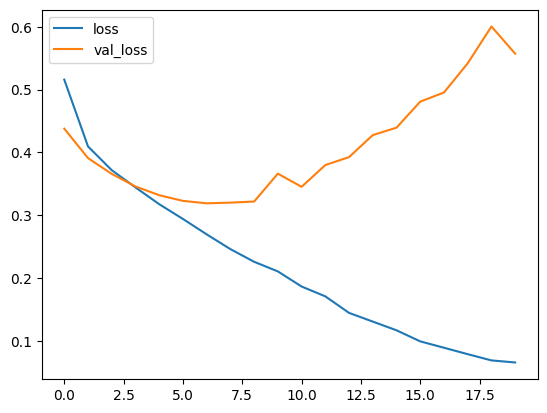

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")
print("Accuracy of the model on Validation Data is - " , model.evaluate(X_valid,y_valid)[1]*100 , "%")

1588/1588 [==============================] - 298s 188ms/step - loss: 0.0202 - accuracy: 0.9952 - f1_score: 0.9959
Accuracy of the model on Training Data is -  99.52357411384583 %
199/199 [==============================] - 37s 187ms/step - loss: 0.5570 - accuracy: 0.8497 - f1_score: 0.8692
Accuracy of the model on Testing Data is -  84.97400879859924 %
199/199 [==============================] - 37s 184ms/step - loss: 0.5546 - accuracy: 0.8584 - f1_score: 0.8770
Accuracy of the model on Validation Data is -  85.84251999855042 %


#GRU_NN

In [ ]:
batch_size = 2048
epochs = 20

In [ ]:
def gru_scheduler(epoch, lr):
  if epoch < 12:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

learning_rate_reduction_decay = LearningRateScheduler(schedule = scheduler, verbose = 1)

In [ ]:
import tensorflow_addons as tfa
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(GRU(units=128, activation='tanh', recurrent_activation='sigmoid', return_sequences = True, recurrent_dropout = 0.2 , dropout = 0.3))
model.add(GRU(units=64, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout = 0.25 , dropout = 0.25))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.005), loss='binary_crossentropy', 
              metrics=['accuracy', tfa.metrics.F1Score(num_classes = 1, threshold = 0.5)])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          6000000   
                                                                 
 gru (GRU)                   (None, 300, 128)          165120    
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,204,481
Trainable params: 204,481
Non-trainable params: 6,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/20
25/25 [==============================] - 69s 3s/step - loss: 0.5258 - accuracy: 0.7376 - f1_score: 0.7953 - val_loss: 0.4510 - val_accuracy: 0.7899 - val_f1_score: 0.8348 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/20
25/25 [==============================] - 60s 2s/step - loss: 0.4144 - accuracy: 0.8010 - f1_score: 0.8399 - val_loss: 0.3807 - val_accuracy: 0.8157 - val_f1_score: 0.8499 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/20
25/25 [==============================] - 61s 2s/step - loss: 0.3724 - accuracy: 0.8237 - f1_score: 0.8572 - val_loss: 0.3551 - val_accuracy: 0.8274 - val_f1_score: 0.8588 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/20
25/25 [==============================] - 60s 2s/step - loss: 0.3457 - accuracy: 0.8396 -

<Axes: >

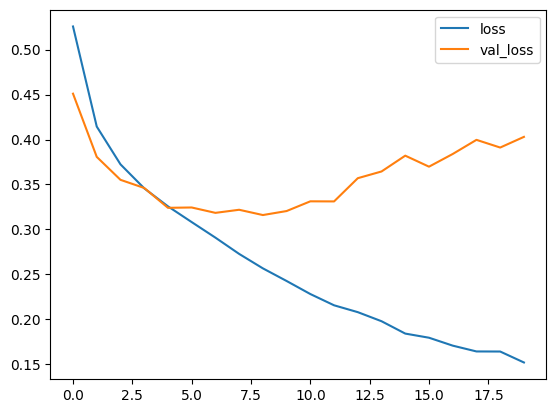

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")
print("Accuracy of the model on Validation Data is - " , model.evaluate(X_valid,y_valid)[1]*100 , "%")

1588/1588 [==============================] - 284s 179ms/step - loss: 0.0664 - accuracy: 0.9782 - f1_score: 0.9813
Accuracy of the model on Training Data is -  97.82459139823914 %
199/199 [==============================] - 35s 176ms/step - loss: 0.4029 - accuracy: 0.8611 - f1_score: 0.8805
Accuracy of the model on Testing Data is -  86.10804677009583 %
199/199 [==============================] - 35s 175ms/step - loss: 0.4202 - accuracy: 0.8581 - f1_score: 0.8775
Accuracy of the model on Validation Data is -  85.8110249042511 %
